# Imagenette - Please scroll to the end for final best runs (MobileNet + AdamW) - 86.96 in 1 epoch
## MobileNet:
- Howard, A. G., Zhu, M., Chen, B., Kalenichenko, D., Wang, W., Weyand, T., ... & Adam, H. (2017). Mobilenets: Efficient convolutional neural networks for mobile vision applications. arXiv preprint arXiv:1704.04861.

In [1]:
from fastai import *
from fastai.vision import *
import torch.onnx
from torch.autograd import Variable
import netron
import os

os.environ["TORCH_HOME"] = "/media/subhaditya/DATA/COSMO/Datasets-Useful"

In [2]:
path = untar_data(URLs.IMAGENETTE_160)

In [3]:
data = (
    (
        ImageList.from_folder(path)
        .split_by_rand_pct()
        .label_from_folder()
        .transform(get_transforms(), size=128)
    )
    .databunch(bs=64)
    .normalize(imagenet_stats)
)

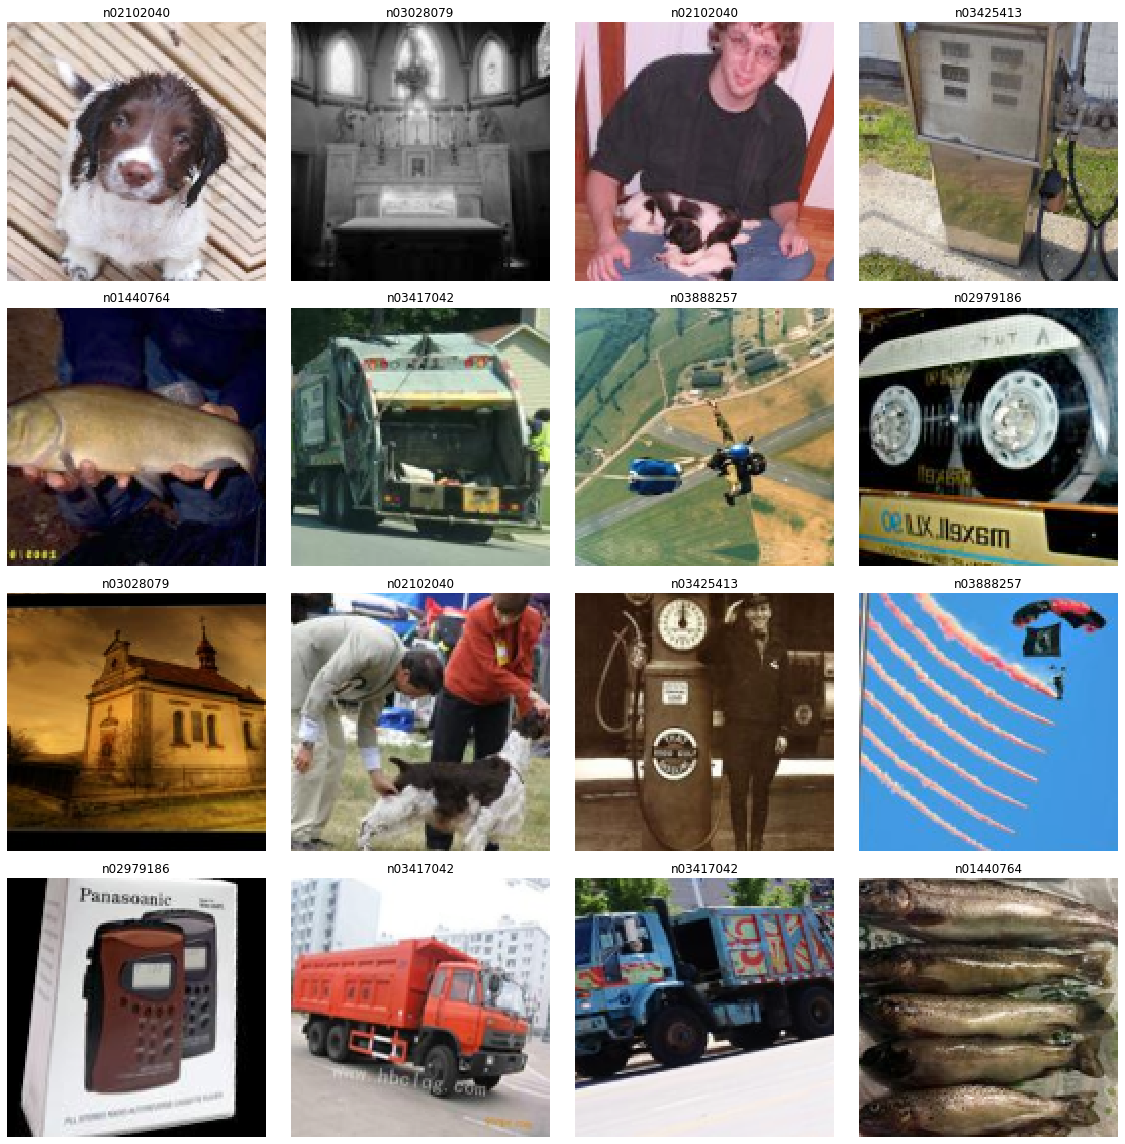

In [4]:
data.show_batch(4)

In [5]:
data.c

10

## Lamb

In [6]:
import collections
import math
from torch.optim import Optimizer
import torch


class Lamb(Optimizer):
    r"""Implements Lamb algorithm.
    It has been proposed in `Large Batch Optimization for Deep Learning: Training BERT in 76 minutes`_.
    Arguments:
        params (iterable): iterable of parameters to optimize or dicts defining
            parameter groups
        lr (float, optional): learning rate (default: 1e-3)
        betas (Tuple[float, float], optional): coefficients used for computing
            running averages of gradient and its square (default: (0.9, 0.999))
        eps (float, optional): term added to the denominator to improve
            numerical stability (default: 1e-8)
        weight_decay (float, optional): weight decay (L2 penalty) (default: 0)
        adam (bool, optional): always use trust ratio = 1, which turns this into
            Adam. Useful for comparison purposes.
    .. _Large Batch Optimization for Deep Learning: Training BERT in 76 minutes:
        https://arxiv.org/abs/1904.00962
    """

    def __init__(
        self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-6, weight_decay=0, adam=False
    ):
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {}".format(eps))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError("Invalid beta parameter at index 0: {}".format(betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError("Invalid beta parameter at index 1: {}".format(betas[1]))
        defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay)
        self.adam = adam
        super(Lamb, self).__init__(params, defaults)

    def step(self, closure=None):
        """Performs a single optimization step.
        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            for p in group["params"]:
                if p.grad is None:
                    continue
                grad = p.grad.data
                if grad.is_sparse:
                    raise RuntimeError(
                        "Lamb does not support sparse gradients, consider SparseAdam instad."
                    )

                state = self.state[p]

                # State initialization
                if len(state) == 0:
                    state["step"] = 0
                    # Exponential moving average of gradient values
                    state["exp_avg"] = torch.zeros_like(p.data)
                    # Exponential moving average of squared gradient values
                    state["exp_avg_sq"] = torch.zeros_like(p.data)

                exp_avg, exp_avg_sq = state["exp_avg"], state["exp_avg_sq"]
                beta1, beta2 = group["betas"]

                state["step"] += 1

                # Decay the first and second moment running average coefficient
                # m_t
                exp_avg.mul_(beta1).add_(1 - beta1, grad)
                # v_t
                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)

                # Paper v3 does not use debiasing.
                # bias_correction1 = 1 - beta1 ** state['step']
                # bias_correction2 = 1 - beta2 ** state['step']
                # Apply bias to lr to avoid broadcast.
                step_size = group[
                    "lr"
                ]  # * math.sqrt(bias_correction2) / bias_correction1

                weight_norm = p.data.pow(2).sum().sqrt().clamp(0, 10)

                adam_step = exp_avg / exp_avg_sq.sqrt().add(group["eps"])
                if group["weight_decay"] != 0:
                    adam_step.add_(group["weight_decay"], p.data)

                adam_norm = adam_step.pow(2).sum().sqrt()
                if weight_norm == 0 or adam_norm == 0:
                    trust_ratio = 1
                else:
                    trust_ratio = weight_norm / adam_norm
                state["weight_norm"] = weight_norm
                state["adam_norm"] = adam_norm
                state["trust_ratio"] = trust_ratio
                if self.adam:
                    trust_ratio = 1

                p.data.add_(-step_size * trust_ratio, adam_step)

        return loss

In [15]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 32, 3, 2, 1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
        )
        self.lin1 = nn.Linear(1024, 100)
        self.convn = nn.Sequential(  # depthwise when changing from a smaller to bigger layer
            self.conv_block(32, 64, 1),
            self.conv_block(64, 128, 2),
            self.conv_block(128, 128, 1),
            self.conv_block(128, 256, 2),
            self.conv_block(256, 256, 1),
            self.conv_block(256, 512, 2),
            self.conv_block(512, 512, 1),
            self.conv_block(512, 512, 1),
            self.conv_block(512, 512, 1),
            self.conv_block(512, 512, 1),
            self.conv_block(512, 512, 1),
            self.conv_block(512, 1024, 2),
            self.conv_block(1024, 1024, 1),
            nn.AvgPool2d(4),
        )

    def conv_block(self, inb, out, stride):
        return nn.Sequential(
            nn.Conv2d(
                inb, inb, 3, stride, 1, groups=inb, bias=False
            ),  # groups -> no of blocks -> depthwise conv
            nn.BatchNorm2d(inb),
            nn.ReLU(inplace=True),
            nn.Conv2d(inb, out, 1, 1, 0, bias=False),
            nn.BatchNorm2d(out),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.convn(x)
        x = x.view(-1, 1024)
        x = self.lin1(x)

        return x

In [16]:
model = Model()

In [17]:
learn = Learner(data, model, metrics=[accuracy], opt_func=Lamb, callback_fns=ShowGraph)

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


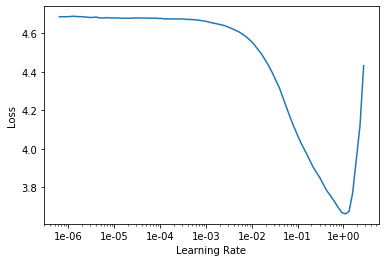

In [18]:
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,accuracy,time
0,2.431528,2.656383,0.251307,03:16
1,1.878972,3.277205,0.250187,03:09
2,1.713673,3.173334,0.266243,03:12
3,1.494634,1.606222,0.495892,03:07
4,1.290671,1.129896,0.637789,03:07
5,1.161548,1.213064,0.603809,03:07
6,1.017201,1.005107,0.678865,03:08
7,0.877272,0.790178,0.747199,03:08
8,0.748176,0.685390,0.771845,03:09
9,0.701825,0.653386,0.788275,03:09


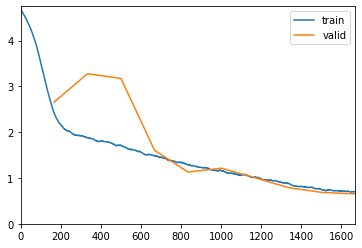

In [19]:
learn.fit_one_cycle(10, 2e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.717653,0.709866,0.786034,03:09
1,0.825319,1.216883,0.606423,03:12
2,0.912380,1.042437,0.675131,03:12
3,0.878682,1.137028,0.641524,03:07
4,0.842727,0.896688,0.728902,03:07
5,0.775575,0.742866,0.766243,03:07
6,0.654612,0.672794,0.794249,03:07
7,0.588830,0.588899,0.814040,03:08
8,0.482352,0.513976,0.834951,03:07
9,0.417665,0.488241,0.849888,03:09


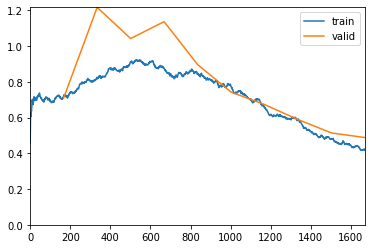

In [20]:
learn.unfreeze()
learn.fit_one_cycle(10, 2e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.461345,0.624013,0.808066,03:06
1,0.604326,0.875163,0.746453,03:08
2,0.688187,0.927294,0.710605,03:08
3,0.701904,0.715180,0.783047,03:09
4,0.658446,0.739663,0.766990,03:11
5,0.619465,0.819553,0.740851,03:14
6,0.524927,0.569584,0.823749,03:17
7,0.451117,0.493873,0.849888,03:09
8,0.380963,0.439359,0.862957,03:14
9,0.318806,0.437591,0.868559,03:16


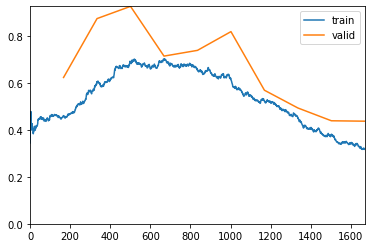

In [22]:
learn.unfreeze()
learn.fit_one_cycle(10, 2e-2)

In [23]:
learn.save('stage-1')

In [36]:
learn.load('stage-1')

Learner(data=ImageDataBunch;

Train: LabelList (10716 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
n03028079,n03028079,n03028079,n03028079,n03028079
Path: /home/subhaditya/.fastai/data/imagenette2-160;

Valid: LabelList (2678 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
n03028079,n03425413,n02102040,n03394916,n03000684
Path: /home/subhaditya/.fastai/data/imagenette2-160;

Test: None, model=Model(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (lin1): Linear(in_features=1024, out_features=100, bias=True)
  (convn): Sequential(
    (0): Sequential(
      (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), gro

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


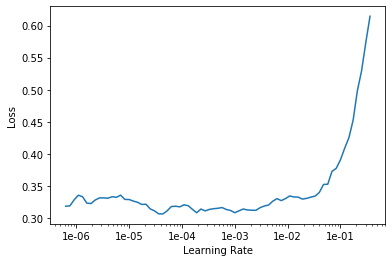

In [26]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,accuracy,time
0,0.405825,0.553610,0.833831,03:26
1,0.409445,0.532783,0.836819,03:22
2,0.311442,0.433008,0.868185,03:28


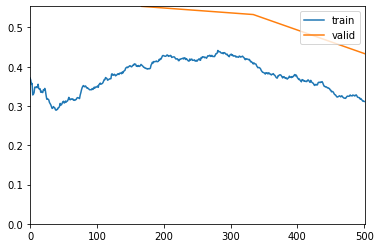

In [37]:
learn.unfreeze()
learn.fit_one_cycle(3, 1e-2)

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


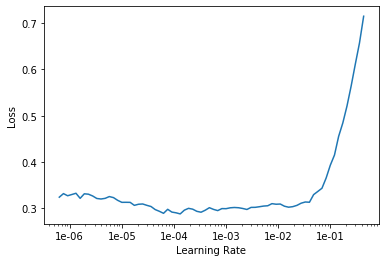

In [38]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,accuracy,time
0,0.287937,0.433914,0.869305,03:25
1,0.284993,0.432176,0.868185,03:20
2,0.281833,0.433564,0.868932,03:19


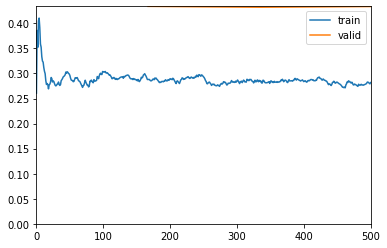

In [39]:
learn.unfreeze()
learn.fit_one_cycle(3, 4e-5)

In [40]:
learn.save('stage-n-mobilelamb')

## AdamW

In [42]:
learn = None
gc.collect()

7696

In [49]:
learn = Learner(data, model, metrics=[accuracy], opt_func=AdamW, callback_fns=ShowGraph)

In [50]:
# learn.lr_find()
# learn.recorder.plot()

epoch,train_loss,valid_loss,accuracy,time
0,0.274590,0.430004,0.868559,03:21
1,0.259266,0.430352,0.870426,03:19
2,0.276702,0.430748,0.868185,03:11
3,0.275769,0.425129,0.871172,03:13
4,0.274991,0.426681,0.867065,03:26


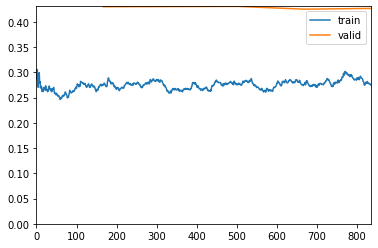

In [45]:
learn.fit_one_cycle(5, 3e-5)

In [46]:
learn.save('mn-1')

## Train again with AdamW (2 epochs)

In [49]:
learn = Learner(data, model, metrics=[accuracy], opt_func=AdamW, callback_fns=ShowGraph)

epoch,train_loss,valid_loss,accuracy,time
0,0.270903,0.430931,0.870799,03:27
1,0.275676,0.427092,0.869679,03:20


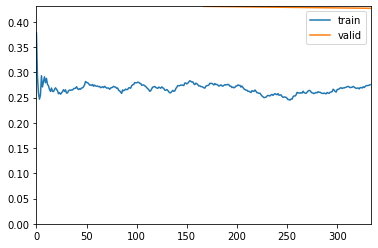

In [51]:
learn.fit_one_cycle(2, 3e-5)

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


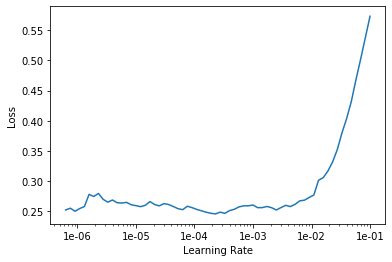

In [52]:
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,accuracy,time
0,0.254001,0.427982,0.866692,03:23
1,0.260656,0.428432,0.866318,03:16


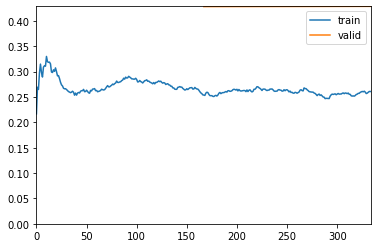

In [53]:
learn.fit_one_cycle(2, 6e-5)

In [54]:
learn.save('mobile-adamW-fin')